In [1]:
#### Use this to create reference spectra with convolution

In [1]:
import numpy as np
import glob
import scipy.signal as scs
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, VoigtModel, LinearModel, ConstantModel
import sys
sys.path.append('C:\\JUNOx23_PC\\NO2CRDCEAS\\')
import CESfunctionsJUNOx23 as cf

In [3]:
### Load the reference spectra and a sample from the spectrometers, set calibration factors and calibrate pixels
### to new wavelengths

In [4]:
ref1=np.loadtxt("NO3.txt")
#ref2=np.load("CHOCHO.npy")
spec=np.loadtxt('NeLamp.asc',delimiter=',')
calfactors=(3.10322588e+02,1.72905279e-01,-1.48816626e-05,1.95619706e-09)
wavelengths=cf.andor_calibrator(len(spec[:,0]),*calfactors)

In [5]:
print(spec.shape,wavelengths.shape)
print(spec[:,0])
print(wavelengths[:,0])

(1024, 2) (1024, 1)
[1.000e+00 2.000e+00 3.000e+00 ... 1.022e+03 1.023e+03 1.024e+03]
[310.4954784  310.66833905 310.84116995 ... 473.57629195 473.72489988
 473.87349005]


In [6]:
### Interpolate the references to the calibrated wavelengths

In [7]:
ref1int = np.interp(wavelengths[:,0],ref1[:,0],ref1[:,1])
#ref2int = np.interp(wavelengths[:,0],ref2[:,0],ref2[:,1])

In [8]:
### Check them out

Text(0.5, 1.0, 'Reference and Interpolation')

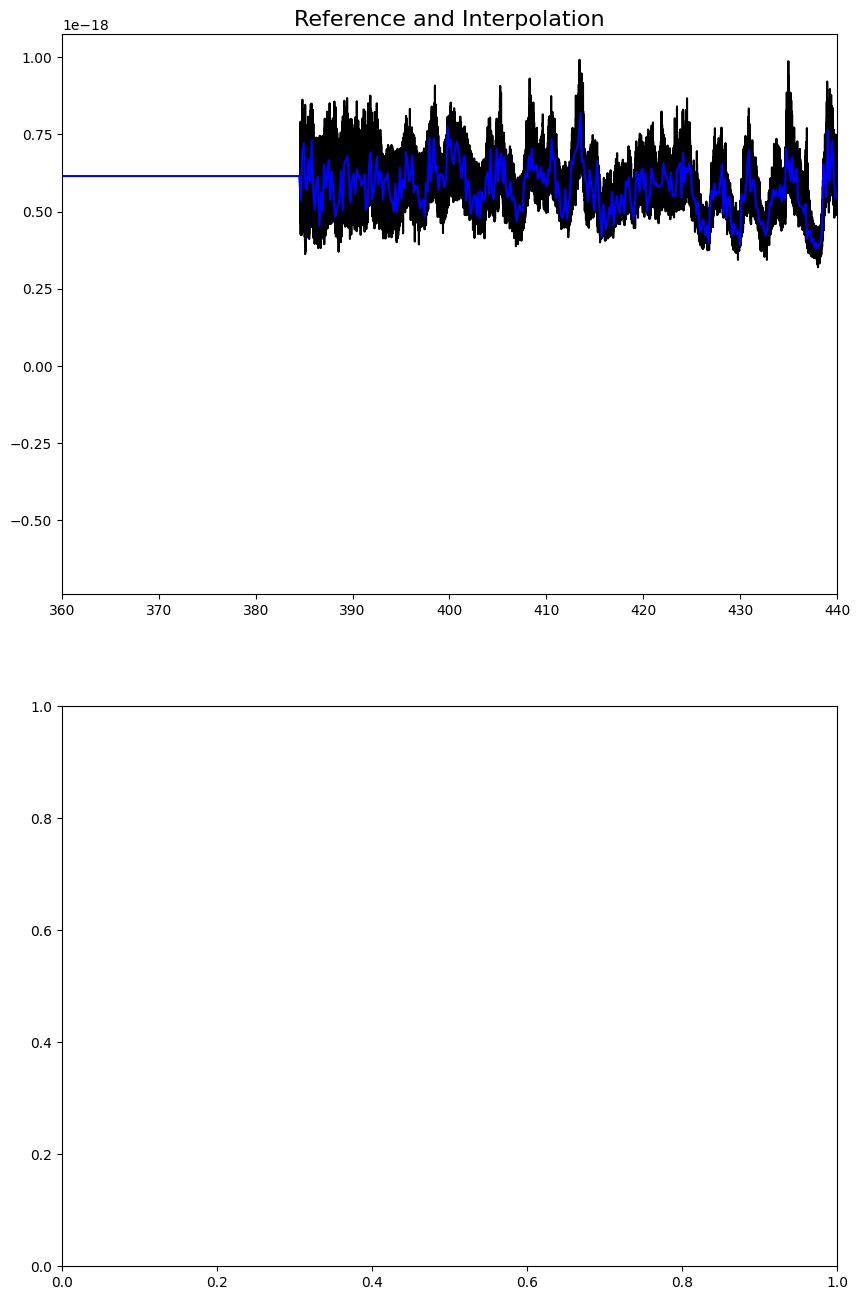

In [9]:
f = plt.figure(figsize=(10,16))
ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

ax1.plot(ref1[:,0],ref1[:,1],'-k')
ax1.plot(wavelengths[:,0],ref1int,'-b')
ax1.set_xlim(360,440)
ax1.set_title("Reference and Interpolation",size=16)

#ax2.plot(ref2[:,0],ref2[:,1],'-k')
#ax2.plot(wavelengths[:,0],ref2int,'-b')
#ax2.set_xlim(430,470)
#ax2.set_title("Reference and Interpolation",size=16)

In [10]:
### Load the lineshape and change the uncalibrated wavelengths for the new ones
### In this case hglamp is taken with AvaSoft so it has 1 less pixel

In [11]:
#hglamp = np.load("hglamp.npy")
hglamp=np.loadtxt('hglamp.asc',delimiter=',')
hglamp_cal = np.concatenate((wavelengths[:,:],hglamp[:,1].reshape(len(hglamp[:,1]),1)),axis=1)

In [12]:
### Check out your lines

Text(0.5, 1.0, 'Calibration lines')

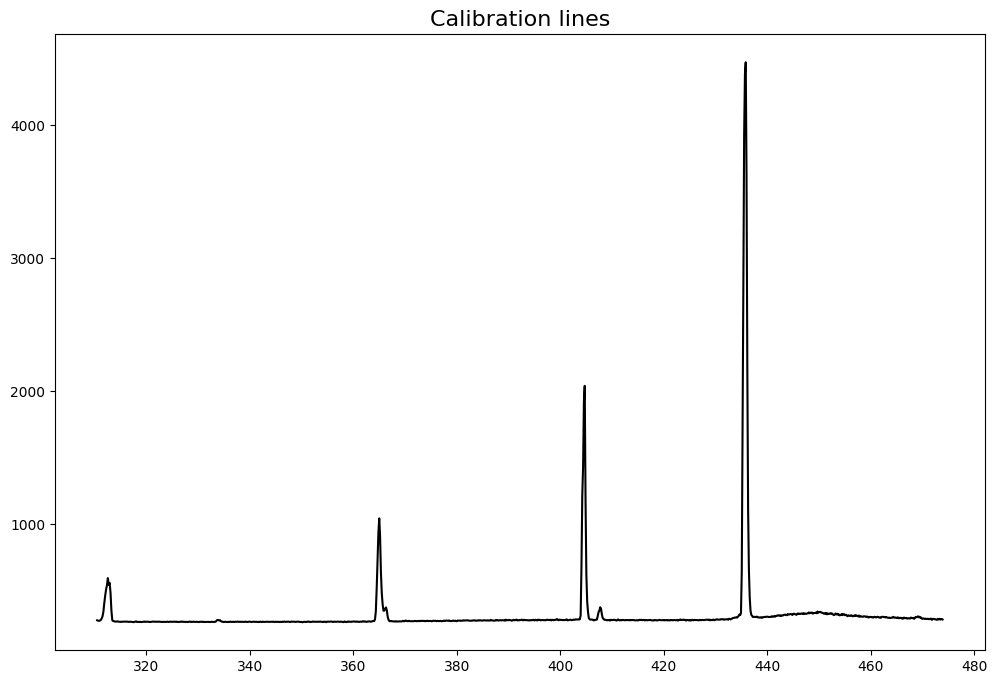

In [13]:
f = plt.figure(figsize=(12,8))
ax1 = f.add_subplot(111)

ax1.plot(hglamp_cal[:,0],hglamp_cal[:,1],'-k')
ax1.set_title("Calibration lines",size=16)


In [14]:
### Find the line closer to your range, get its maximun, center it with and get your lineshape vector

In [15]:
section=np.nonzero((hglamp_cal[:,0]<=405) & (hglamp_cal[:,0]>=403))
center=np.nonzero(hglamp_cal[:,1]==np.amax(hglamp_cal[section[0][0]:section[0][-1],1]))
lineshape = np.copy(hglamp_cal[center[0][0]-10:center[0][0]+11,:])
lineshape[:,1]=lineshape[:,1]-np.amin(lineshape[:,1])
lineshape[:,1]=(lineshape[:,1])/(np.amax(lineshape[:,1]))

In [16]:
np.amin(lineshape[:,1])

0.0

In [17]:
### Let's fit the lineshape to some Gaussian and Voigt profiles using lmfit

In [18]:
model = GaussianModel()
model2 = VoigtModel()

# create parameters with initial values
params = model.make_params(amplitude=1, center=404.65,sigma=.5)
params2 = model2.make_params(amplitude=1, center=404.65,sigma=.5)

# maybe place bounds on some parameters
#params['center'].min = 2
#params['center'].max = 12
#params['amplitude'].max = 0. 

# do the fit, print out report with results 
result = model.fit(lineshape[:,1], params, x=lineshape[:,0])
result2 = model2.fit(lineshape[:,1], params2, x=lineshape[:,0])
print(result.fit_report())
print(result2.fit_report())

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 21
    # variables        = 3
    chi-square         = 0.04942601
    reduced chi-square = 0.00274589
    Akaike info crit   = -121.087818
    Bayesian info crit = -117.954251
    R-squared          = 0.97642118
[[Variables]]
    amplitude:  0.66205353 +/- 0.02501598 (3.78%) (init = 1)
    center:     404.592773 +/- 0.01184977 (0.00%) (init = 404.65)
    sigma:      0.27157939 +/- 0.01184970 (4.36%) (init = 0.5)
    fwhm:       0.63952058 +/- 0.02790390 (4.36%) == '2.3548200*sigma'
    height:     0.97253756 +/- 0.03674911 (3.78%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = +0.5773
[[Model]]
    Model(voigt)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 21
    # variables        = 3
    chi-square         = 0.0737546

In [19]:
### Check your lineshape and the fits

Text(0.5, 1.0, 'Line shape and fits')

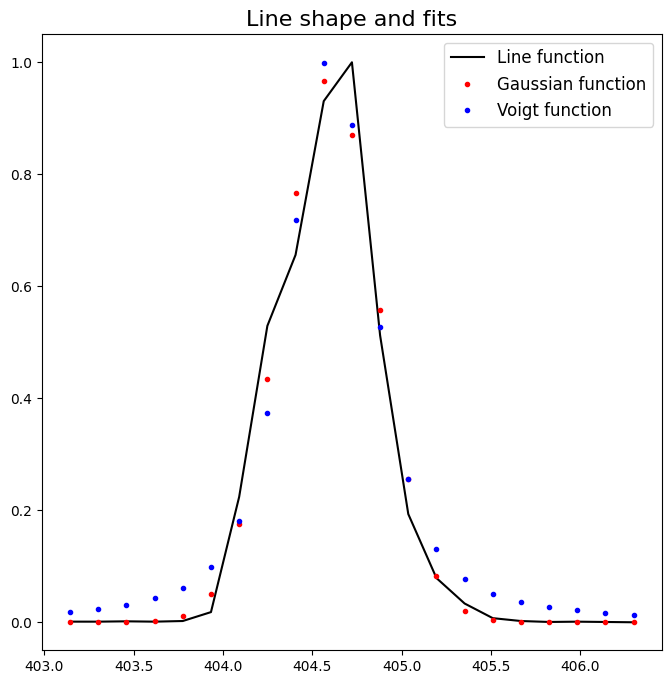

In [20]:
f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
ax1.plot(lineshape[:,0],lineshape[:,1]-np.amin(lineshape[:,1]),'-k',label="Line function")
ax1.plot(lineshape[:,0],result.best_fit,'.r',label="Gaussian function")
ax1.plot(lineshape[:,0],result2.best_fit,'.b',label="Voigt function")
ax1.legend(fontsize=12, loc='upper right')
ax1.set_title("Line shape and fits",size=16)

In [21]:
### Perform the convolution with the original lineshape and the fits

In [22]:
conv11 = np.convolve(ref1int,lineshape[:,1],mode='same')
#conv12 = np.convolve(ref2int,lineshape[:,1],mode='same')
conv21 = np.convolve(ref1int,result.best_fit,mode="same")
#conv22 = np.convolve(ref2int,result.best_fit,mode="same")
conv31 = np.convolve(ref1int,result2.best_fit,mode="same")
#conv32 = np.convolve(ref2int,result2.best_fit,mode="same")

In [23]:
### Check your convolutions and adjust the best fit
### In this case we adjust the original lineshape until it fits our desired region

Text(0.5, 1.0, 'Reference 1 convolutions')

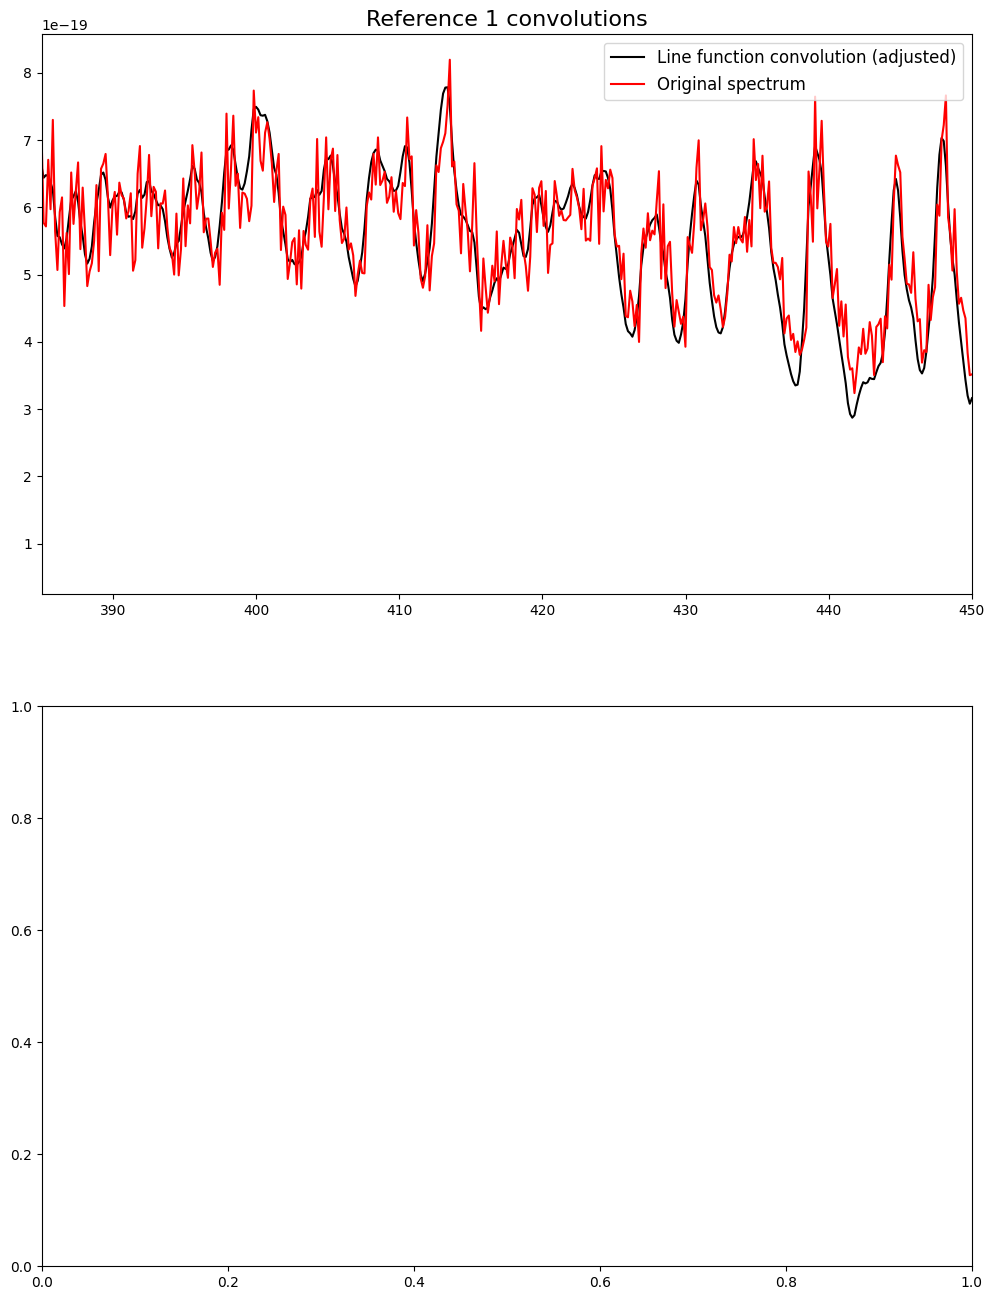

In [28]:
f = plt.figure(figsize=(12,16))
ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

#ax1.plot(wavelengths[:,0],conv11,'-b',label="Line function convolution")
#ax1.plot(wavelengths[:,0],conv21,'-g',label="Gaussian function convolution")
#ax1.plot(wavelengths[:,0],conv31,'-m',label="Voigt function convolution")
ax1.plot(wavelengths[:,0],conv11/3.1-2e-19,'-k',label="Line function convolution (adjusted)")
ax1.plot(wavelengths[:,0],ref1int,'-r',label="Original spectrum")
ax1.set_xlim(385,450)
ax1.legend(fontsize=12, loc='upper right')
ax1.set_title("Reference 1 convolutions",size=16)

#ax2.plot(wavelengths[:,0],conv12,'-b',label="Line function convolution")
#ax2.plot(wavelengths[:,0],conv22,'-g',label="Gaussian function convolution")
#ax2.plot(wavelengths[:,0],conv32,'-m',label="Voigt function convolution")
#ax2.plot(wavelengths[:,0],conv12/6,'-k',label="Line function convolution (adjusted)")
#ax2.plot(wavelengths[:,0],ref2int,'-r',label="Original spectrum")
#ax2.set_xlim(400,500)
#ax2.legend(fontsize=12, loc='upper right')
#ax1.set_title("Reference 2 convolutions",size=16)

In [25]:
### Export your convoluted references interpolated to the calibrated wavelegths

In [29]:
ref1conv=conv11/3.1-2e-19
#ref2conv=conv12/6

np.save("NO2_JUNOx23",np.concatenate((wavelengths,ref1conv.reshape(len(ref1conv),1)),axis=1))
#np.save("CHOCHO_AvSC",np.concatenate((wavelengths,ref2conv.reshape(len(ref2conv),1)),axis=1))

In [ ]:
calfactors=(3.10322588e+02-3.3, 1.72905279e-01,
            -1.48816626e-05,1.95619706e-09)

wls = cf.avantes_calibrator(1024,*calfactors)

In [58]:
import glob
import numpy as np
files = glob.glob('.\\Imref\\Im*')
background=np.loadtxt('.\\Imref\\Ib.txt')
zeroair=np.loadtxt('.\\Imref\\Iz.txt')
Ims = np.copy(background[:,0])

for ele in files:
    Im = np.loadtxt(ele)
    Ims = np.column_stack((Ims,Im[:,1]))
Im = np.average(Ims[:,1:],axis=1)
Im = np.column_stack((Ims[:,0],Im))

In [59]:
start_avg=3
lower_wavelength = 395
upper_wavelength = 420
#background=np.loadtxt('Ib.txt')
#zeroair=np.loadtxt('Iz.txt')
#Im=np.loadtxt('Im.txt')
no2reference= np.load('NO2_JUNOx23.npy')
Refff = np.load('Reff.npy')
Reff = Refff.reshape(len(Refff),1)

counts = np.copy(Im[:,1]).reshape(len(Im[:,1]),1)
minwave,maxwave = cf.segment_indices(no2reference,lower_wavelength,
                upper_wavelength)

bckg = np.copy(background[minwave:maxwave,:])
zero = np.copy(zeroair[minwave:maxwave,:])
no2ref = np.copy(no2reference[minwave:maxwave,:])
I_s = np.copy(counts[minwave:maxwave,:])
I_b = np.average(bckg[:,1:],axis=1).reshape(len(bckg),1)
I_not = np.average(zero[:,start_avg:],axis=1).reshape(len(zero),1)
I_0 = np.subtract(I_not,I_b)
I_sample = np.subtract(I_s,I_b)
alpha = cf.extinction(I_sample,I_0,Reff,44.17)

Text(0.5, 1.0, 'Reference 1 convolutions')

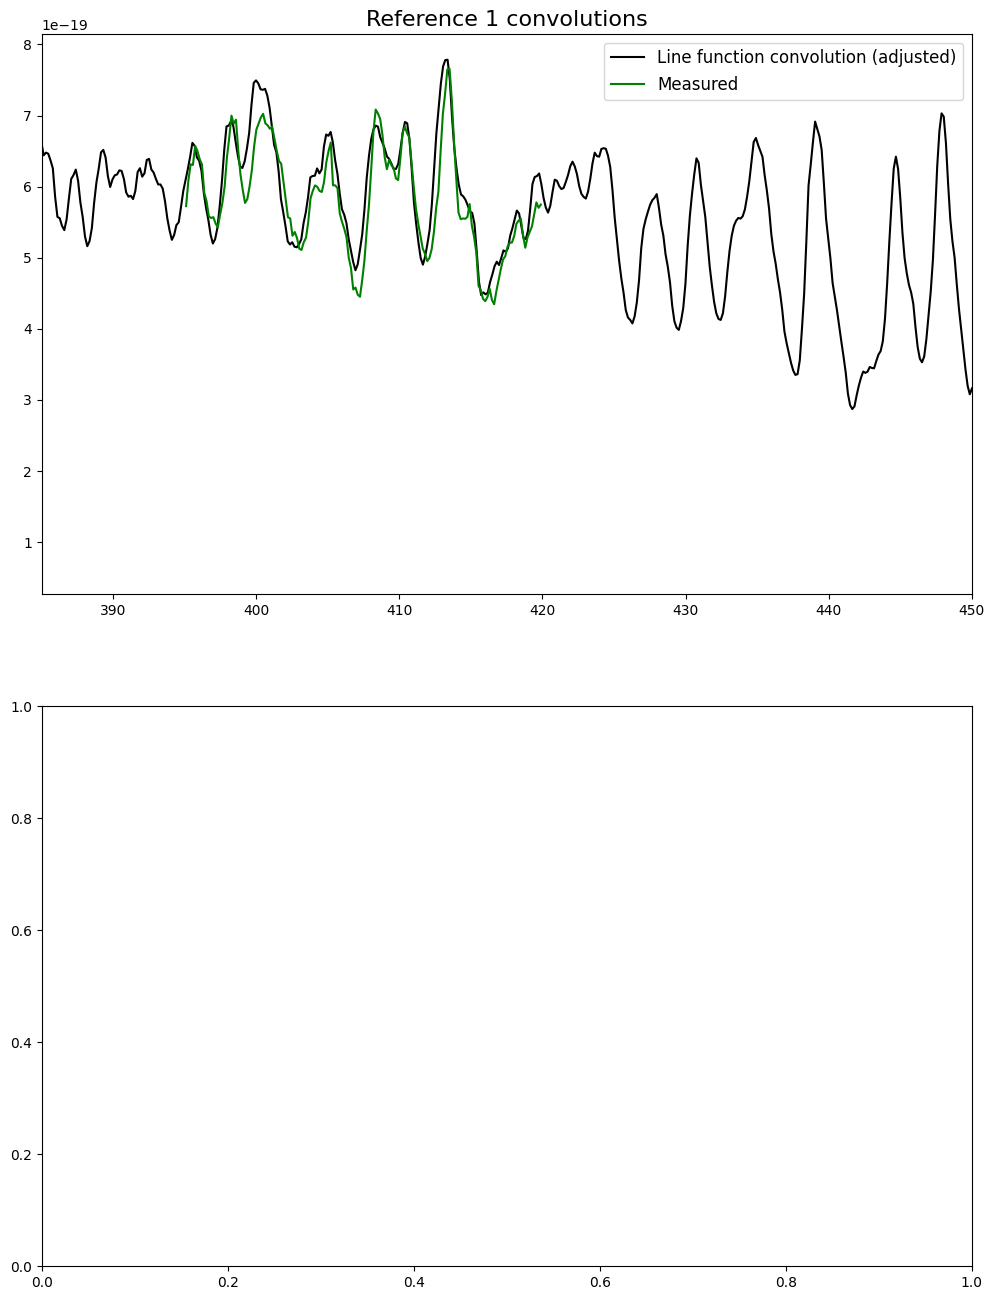

In [72]:
f = plt.figure(figsize=(12,16))
ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

#ax1.plot(wavelengths[:,0],conv11,'-b',label="Line function convolution")
#ax1.plot(wavelengths[:,0],conv21,'-g',label="Gaussian function convolution")
#ax1.plot(wavelengths[:,0],conv31,'-m',label="Voigt function convolution")
ax1.plot(wavelengths[:,0],conv11/3.1-2e-19,'-k',label="Line function convolution (adjusted)")
#ax1.plot(wavelengths[:,0],ref1int,'-r',label="Original spectrum")
ax1.plot(no2ref[:,0],alpha/29.50e11-2.4e-19,'-g',label="Measured")
ax1.set_xlim(385,450)
ax1.legend(fontsize=12, loc='upper right')
ax1.set_title("Reference 1 convolutions",size=16)

#ax2.plot(wavelengths[:,0],conv12,'-b',label="Line function convolution")
#ax2.plot(wavelengths[:,0],conv22,'-g',label="Gaussian function convolution")
#ax2.plot(wavelengths[:,0],conv32,'-m',label="Voigt function convolution")
#ax2.plot(wavelengths[:,0],conv12/6,'-k',label="Line function convolution (adjusted)")
#ax2.plot(wavelengths[:,0],ref2int,'-r',label="Original spectrum")
#ax2.set_xlim(400,500)
#ax2.legend(fontsize=12, loc='upper right')
#ax1.set_title("Reference 2 convolutions",size=16)

In [74]:
meas_ref = np.column_stack((no2ref[:,0],alpha/29.50e11-2.4e-19))

In [75]:
meas_ref.shape

(159, 2)

Text(0.5, 1.0, 'Reference 1 convolutions')

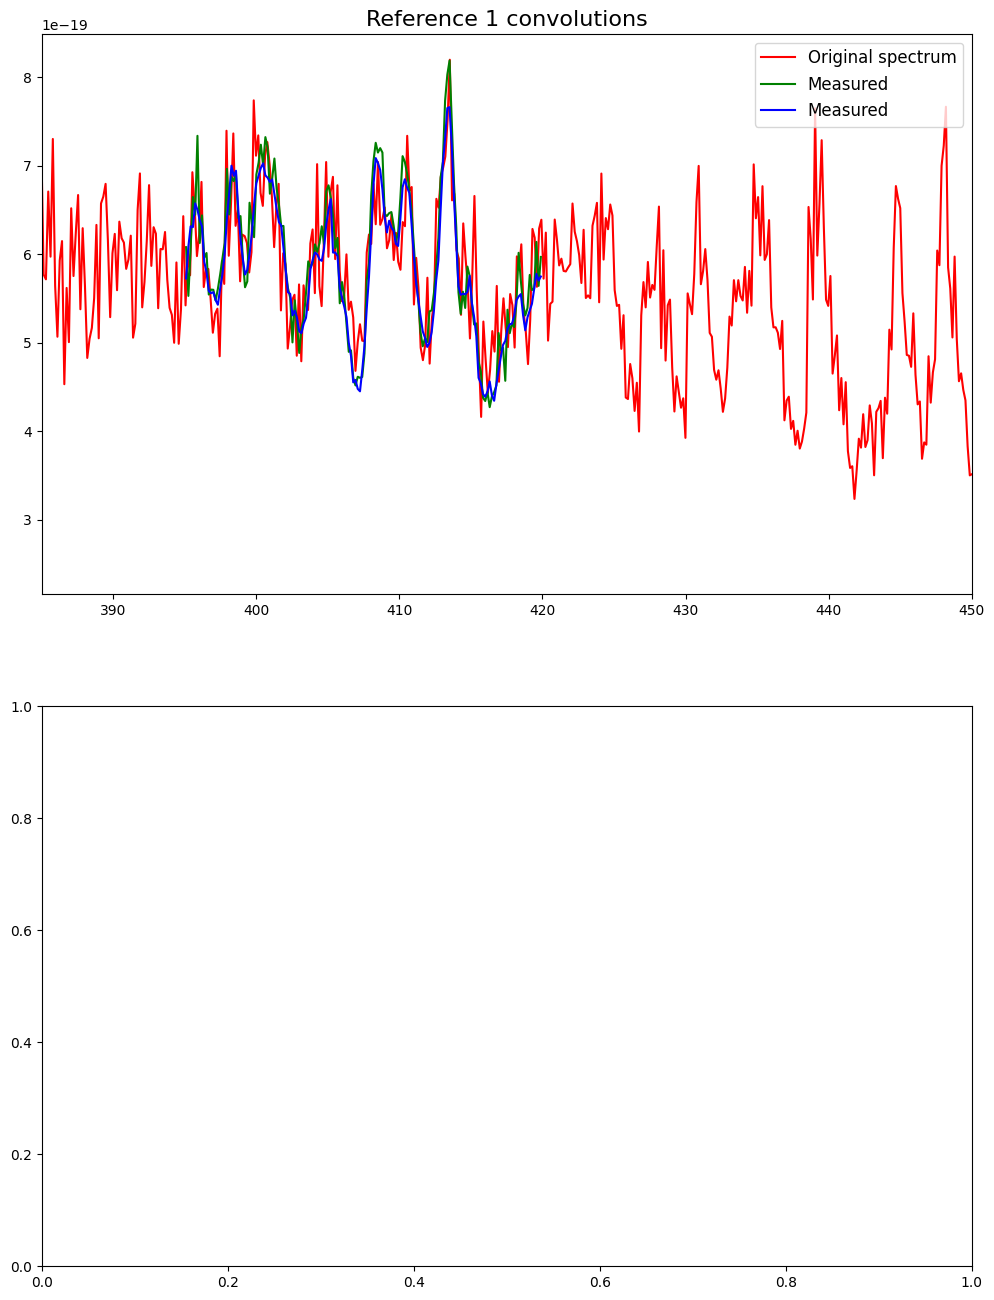

In [73]:
f = plt.figure(figsize=(12,16))
ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

#ax1.plot(wavelengths[:,0],conv11,'-b',label="Line function convolution")
#ax1.plot(wavelengths[:,0],conv21,'-g',label="Gaussian function convolution")
#ax1.plot(wavelengths[:,0],conv31,'-m',label="Voigt function convolution")
#ax1.plot(wavelengths[:,0],conv11/3.1-2e-19,'-k',label="Line function convolution (adjusted)")
ax1.plot(wavelengths[:,0],ref1int,'-r',label="Original spectrum")
ax1.plot(meas_ref[:,0],meas_ref[:,1],'-g',label="Measured")
ax1.plot(no2ref[:,0],alpha/29.50e11-2.4e-19,'-b',label="Measured")
ax1.set_xlim(385,450)
ax1.legend(fontsize=12, loc='upper right')
ax1.set_title("Reference 1 convolutions",size=16)


In [76]:
np.savetxt("NO2_JUNOx23_meas.txt",meas_ref)


In [77]:
meas_ref2=np.loadtxt("NO2_JUNOx23_meas.txt")
np.save("NO2_JUNOx23_meas",meas_ref2)

In [78]:
meas_ref2.shape

(1024, 2)

In [81]:
shotsb = 6
shotsz = 6
start_avg = 2
lower_wavelength = 395
upper_wavelength = 420
full_mat = np.load('Ibzmchocho.npy')
background=np.copy(full_mat[:,:shotsb+1])
zeroair=np.copy(full_mat[:,shotsb+1:shotsb+shotsz+2])
Ims = np.copy(full_mat[:,shotsb+shotsz+2:])
no2reference= np.load('NO2_JUNOx23.npy')
Refff = np.load('Reff.npy')
Reff = Refff.reshape(len(Refff),1)

counts = np.copy(Ims[:,186]).reshape(len(Ims[:,186]),1)
minwave,maxwave = cf.segment_indices(no2reference,lower_wavelength,
                upper_wavelength)

bckg = np.copy(background[minwave:maxwave,:])
zero = np.copy(zeroair[minwave:maxwave,:])
no2ref = np.copy(no2reference[minwave:maxwave,:])
I_s = np.copy(counts[minwave:maxwave,:])
I_b = np.average(bckg[:,1:],axis=1).reshape(len(bckg),1)
I_not = np.average(zero[:,start_avg:],axis=1).reshape(len(zero),1)
I_0 = np.subtract(I_not,I_b)
I_sample = np.subtract(I_s,I_b)
alpha = cf.extinction(I_sample,I_0,Reff,44.17)

In [110]:
ref2=np.load("CHOCHO.npy")
ref2int = np.interp(zeroair[:,0],ref2[:,0],ref2[:,1])

meas_ref = np.column_stack((no2ref[:,0],alpha/(330*2.5e10)-0.10e-19))
chochoint = np.column_stack((zeroair[:,0],ref2int))
fullchocho = np.loadtxt('measchocho_full.txt')

Text(0.5, 1.0, 'Reference 1 convolutions')

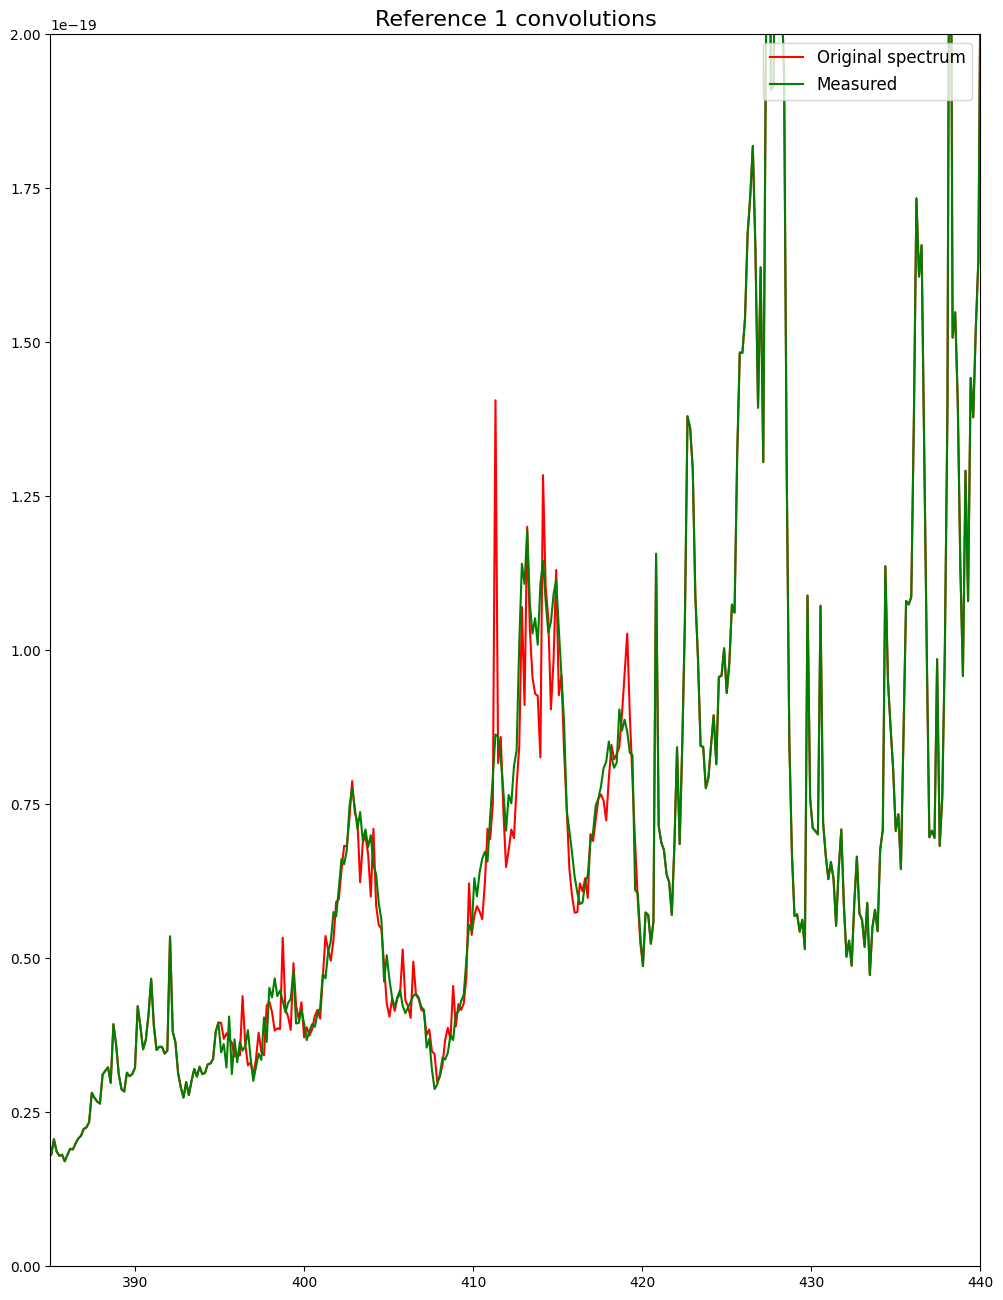

In [111]:
f = plt.figure(figsize=(12,16))
ax1 = f.add_subplot(111)
#ax2 = f.add_subplot(212)

#ax1.plot(wavelengths[:,0],conv11,'-b',label="Line function convolution")
#ax1.plot(wavelengths[:,0],conv21,'-g',label="Gaussian function convolution")
#ax1.plot(wavelengths[:,0],conv31,'-m',label="Voigt function convolution")
#ax1.plot(wavelengths[:,0],conv11/3.1-2e-19,'-k',label="Line function convolution (adjusted)")
ax1.plot(chochoint[:,0],ref2int,'-r',label="Original spectrum")
ax1.plot(fullchocho[:,0],fullchocho[:,1],'-g',label="Measured")
#ax1.plot(no2ref[:,0],alpha/(330*2.5e10)-0.11e-19,'-b',label="Measured")
ax1.set_xlim(385,440)
ax1.set_ylim(0,2e-19)
ax1.legend(fontsize=12, loc='upper right')
ax1.set_title("Reference 1 convolutions",size=16)

In [109]:
np.savetxt('chochoint.txt',chochoint)
np.savetxt('measchocho.txt',meas_ref)

In [112]:
np.save('CHOCHO_JUNOx23',fullchocho)